# COVID politics 2021

### Main ideas

Did people react differently to COVID-19 depending on their political beliefs?
(Does it generate more controversy than other topics controversy?)

This notebook intends to visualize if such relationship exists, and if so, quantify it.

The study is focused in the US due to two main factors:
 - Data availability
 - "Simplified" political landscape
 
### Introduction 
 
It is impossible to separate now 2020 to the pandemic. Despite the certain feeling that COVID-19 paralyzed the world, the pandemic itself has been far from still. The relentless spread of the virus has taken many forms inside ourselves: what is going on in Wuhan? What is going in Italy? How long will the lockdown last? Are masks effective? Which company is making the vaccine? The urgency and total presence of such topics have modified our discussions and the way we discuss them. Speaking of discussing, could the mental takeover be different depending on your political views?

In order to check this, first we will investigate the headlines in the subreddit r/Coronavirus, to discern the main relevant topics that have flooded our conversations during 2020. Then, identifying the clusters of words that are representative from that topic in particular, we can look them up un forums intended to political discussion. In this case, we take advantage of the community based structure of reddit to compare the evolution and impact of those topic in r/republican and r/democrats.


## Data sources

https://reddit-api.readthedocs.io/en/latest/
https://electionlab.mit.edu/data
https://data.cdc.gov/Case-Surveillance/United-States-COVID-19-Cases-and-Deaths-by-State-o/9mfq-cb36
https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/42MVDX

https://reddit-api.readthedocs.io/en/latest/#comments-search

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import datetime as dt
import time
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import nltk
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import collections
import multiprocessing
from itertools import product

#Import visualization tools for LDA models
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords 
import string

from sklearn.feature_extraction.text import TfidfVectorizer
#Import LDA topic modelling plugin from sklearn
from sklearn.decomposition import LatentDirichletAllocation as LDA
import pyLDAvis
import pyLDAvis.sklearn

# Importing local functions
from COVID_functions import *

pd.options.mode.chained_assignment = None

from colour import Color

In [2]:
data_folder = '/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/data/posts/submissions/coronavirus/'

metadf1_column_titles = ['created_utc',
          'author',
          'subreddit',
          'score',
          'id',
          'title',
          'num_comments',
          'num_crossposts',
          'subreddit_subscribers',
          'author_flair_text',
          'author_flair_type']


stop_words = stopwords.words('english')

stopwords_alt = []
with open('/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/stopword_list.txt', 'r') as file:
    stopwords_alt = file.read().split('\n')
    
stopwords_alt = stopwords_alt + ['time', 'state', '10','–',
                                 '1','2','3','2020','amid','de','en','day',
                                 'people','case','cases','florida','live','update','updating',
                                 'covid19', 'coronavirus','covid','virus']

In [124]:
def tokenizer(text):
    '''
    -covert everything to lowercase
    -remove punctuations
    -remove stopwords
    -stemmer
    '''
    #All characters in this string will be converted to lowercase
    text = text.lower()
    
    #Removing sentence punctuations
    for punctuation_mark in string.punctuation:
        text = text.replace(punctuation_mark,'')
    
    #Creating our list of tokens
    list_of_tokens = text.split(' ')
    #Creating our cleaned tokens list 
    cleaned_tokens = []
    #Let us use a stemmer
    stemmer = SnowballStemmer(language = 'english')
    
    #Removing Stop Words in our list of tokens and any tokens that happens to be empty strings
    for token in list_of_tokens:
        if (not token in stopwords_alt) and (token != ''):
            #Stem tokens
            token_stemmed = stemmer.stem(token)
            #appending our finalized cleaned token
            cleaned_tokens.append(token_stemmed)
    
    return cleaned_tokens



def CountWord(title, word):
    
    from collections import Counter 
    
    tokens = tokenizer(title)
    
    c = Counter(tokens)
    
    if word in c.keys():
        return c[word]
    else:
        return 0


def HasCOVIDword(tokens):
    global word_i
    
    return word_i in tokens


def COVIDwordIndex(string):
    global token_names
    
    return sum([int(x in string)/len(token_names) for x in token_names])

def NumWords(string):
    global tokenizer
    
    return(len(tokenizer(string)))

In [14]:
#time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(praw_submission.created_utc))

# creating empty elements
metadat0 = pd.DataFrame(columns = metadf1_column_titles)
meta_file_path = data_folder + 'metadata1.txt'

metadat0 = pd.read_csv(meta_file_path, sep='\t', header = None, names = metadf1_column_titles)
metadat0['TimeStamp'] = pd.to_datetime(metadat0['created_utc'], unit = 's')
metadat0['date'] = metadat0['TimeStamp'].dt.date
metadat0['period'] = metadat0['TimeStamp'].astype('int')//(1e9*60*60*24*1)
metadat0['period'] = metadat0['TimeStamp'].dt.dayofyear

dc19 = metadat0[metadat0['TimeStamp'].dt.year.isin([2020])]
dc19['hour'] = dc19['TimeStamp'].dt.hour

dc19 = dc19[dc19.period > 22]

dc19['tokens'] = dc19.title.apply(tokenizer)

dc19.head(5)

created_utc             author    subreddit  score      id  \
3   1579760266        blackie6644  Coronavirus      1  esp4td   
4   1579742601         blocketjoe  Coronavirus      1  eslqng   
5   1579773673  Silver_Linings_89  Coronavirus      1  esqzz1   
6   1579774394           SealDrop  Coronavirus      1  esr4as   
7   1579740470          bipboop11  Coronavirus      1  esla8o   

                                               title  num_comments  \
3  how people in Wuhan eat roast bats, bat sushi,...             8   
4          China Is On Lockdown Due To Corona Virus!             3   
5  Modeling the spread of diseases like the Coron...             0   
6                                 CORONA VIRUS MEMES             1   
7                          Disease control questions            10   

   num_crossposts  subreddit_subscribers author_flair_text author_flair_type  \
3               0                    162              None              text   
4               0                    130              None              text   
5               0                    206              None              text   
6               0                    209              None              text   
7               0                    125              None              text   

            TimeStamp        date  period  hour  \
3 2020-01-23 06:17:46  2020-01-23      23     6   
4 2020-01-23 01:23:21  2020-01-23      23     1   
5 2020-01-23 10:01:13  2020-01-23      23    10   
6 2020-01-23 10:13:14  2020-01-23      23    10   
7 2020-01-23 00:47:50  2020-01-23      23     0   

                                              tokens  
3  [wuhan, eat, roast, bat, bat, sushi, bat, soup...  
4                     [china, lockdown, due, corona]  
5                            [model, spread, diseas]  
6                                     [corona, meme]  
7                        [diseas, control, question]

In [7]:
#Instatiate TFIDF Vectorizer
tfidf = TfidfVectorizer(tokenizer = tokenizer,
                            # min_df = 365,
                          min_df = 0.02125, 
                           analyzer='word',
                           ngram_range = (1,1))

#dc19.comments is referring to the text column from my dataframe containing the comments
token_matrix = tfidf.fit_transform(dc19.title)

#If you would like to store the matrix to a dataframe, execute the code below
matrix_df = pd.DataFrame(token_matrix.toarray(), columns = tfidf.get_feature_names())

#I'm looking for the top n words for each topic
token_names = tfidf.get_feature_names()

In [8]:
controversy_topics = ['china', 'lockdown', 'mask', 'death', 'quarantin', 'vaccin']
controversy_topics = token_names


from collections import Counter
from wordcloud import WordCloud, get_single_color_func
from os import path
import os

class colormap_color_func(object):
    """Color func created from matplotlib colormap.

    Parameters
    ----------
    colormap : string or matplotlib colormap
        Colormap to sample from

    Example
    -------
    >>> WordCloud(color_func=colormap_color_func("magma"))

    """
    def __init__(self, colormap):
        import matplotlib.pyplot as plt
        self.colormap = plt.cm.get_cmap(colormap)

    def __call__(self, word, font_size, position, orientation,
                 random_state=None, **kwargs):
        if random_state is None:
            random_state = Random()
        r, g, b, _ = np.maximum(0, 255 * np.array(self.colormap(
            random_state.uniform(0, 1))))
        return "rgb({:.0f}, {:.0f}, {:.0f})".format(r, g, b)
    

# get data directory (using getcwd() is needed to support running example in generated IPython notebook)
d = path.dirname(__file__) if "__file__" in locals() else os.getcwd()

image_folder = '/home/jpre/Documents/DTU/COVIDpolitics2021/COVIDvsPOLITICS/images/'

for mci in controversy_topics:
    
    word_could_dict=Counter([mci])

    # The Symbola font includes most emoji
    font_path = path.join(d, 'fonts', 'GothamBold.ttf')
    wordcloud = WordCloud(width = 840, height = 240, background_color='white',
                          font_path = font_path, color_func=colormap_color_func("magma"),
                          min_font_size =60, max_font_size = 150).generate_from_frequencies(word_could_dict)
    
    plt.figure(figsize=(12,4))
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.savefig(path.join(d,'images',''.join(['wc_',mci,'.png'])), bbox_inches='tight')
    plt.close()

In [52]:
from bokeh.layouts import gridplot, layout, Spacer, row, column
from bokeh.models.annotations import Title
from bokeh.models import ColumnDataSource, Legend, Rect, LegendItem, Span, Arrow, NormalHead, OpenHead, VeeHead
from bokeh.models import BoxAnnotation, Label, InvertedTriangle, Text, Triangle, Line, ImageURL, Image, VArea
from bokeh.models import BasicTicker, ColorBar, LinearColorMapper, PrintfTickFormatter
from bokeh.models import HoverTool, TapTool
from bokeh.plotting import figure, output_file, show, output_notebook, save, show
from bokeh.io import show
from bokeh.embed import components
from bokeh.core.properties import value

from bokeh.palettes import Category20
from bokeh.io import output_file, reset_output

from copy import deepcopy
from scipy.interpolate import interp1d


# Settting the figure object
output_notebook()

Loading BokehJS ...

In [30]:
for w_i in controversy_topics:
    dc19[w_i] = dc19.title.apply(lambda x: CountWord(x, w_i))
    
datest = dc19[['period'] + controversy_topics].groupby('period').agg(np.sum)

datest = datest.join(dc19[['period','TimeStamp']].groupby('period').agg(min), how= 'outer')
datest['date'] = datest.TimeStamp.dt.strftime('%d-%b-%y')

Selecting relevant titles to show when hovering

In [31]:
from localreg import *

#x = np.linspace(1.5, 5, 2000)
#yf = np.sin(x*x)
#y = yf + 0.5*np.random.randn(*x.shape)

for w in controversy_topics:
    name_sm = '_'.join([w,'ks'])
    x = datest.index.to_numpy()
    y = datest[w].to_numpy()
    datest[name_sm] = localreg(x, y, x0 = x, kernel=rbf.epanechnikov, width=14, frac=None)

datest.head()

china  confirm  death  die  health  hospit  infect  lockdown  mask  \
period                                                                       
23          6        1      1    0       1       2       0         1     0   
24         15        3      2    2       2       5       6         0     1   
25         19        3      2    3       0       6      14         2     3   
26         14        6      2    0       1       5       7         0     2   
27         14        7      6    4       0       5      16         1     9   

        outbreak  ...  outbreak_ks  pandem_ks  patient_ks  posit_ks  \
period            ...                                                 
23             1  ...     3.854299   1.357828    1.212899  0.420643   
24             8  ...     4.688849   1.270827    1.133224  0.519597   
25             6  ...     5.137796   1.138132    1.326331  0.559395   
26             3  ...     5.370934   1.007342    1.618766  0.568842   
27             6  ...     5.333600   0.919966    1.867499  0.602951   

        record_ks  report_ks  spread_ks  studi_ks   test_ks vaccin_ks  
period                                                                 
23      -0.211887   0.271376   4.940217  0.594742  0.332619 -0.011697  
24      -0.053740   0.904544   5.424061  0.701681  0.638081  0.384023  
25       0.092855   1.463070   5.803923  0.742189  1.011601  0.578219  
26       0.197846   2.119915   6.180579  0.776500  1.311599  0.668691  
27       0.288599   2.815230   6.434156  0.781441  1.543165  0.747667  

[5 rows x 39 columns]

REMEMBER TO SAVE!!!

In [32]:
datest.to_csv('./data/datest.csv',header = True)

In [33]:

smooth_data = datest[['_'.join([s,'ks']) for s in token_names]]


WORDS_IN_TOPIC = smooth_data.columns.tolist()

nweeks = smooth_data.shape[0]
items = [] # items for legend
bar ={} # bar-information for plotting
x_period = datest.index.to_numpy()
weeks = x_period # adding 1 to 0:23 for readibiltiy

c1 = 'orangered'
tools_to_show = 'hover'

p = figure(plot_width=900, plot_height=500, title = None,
           tools = tools_to_show, tooltips = None, x_range=(24,350), x_axis_type = 'linear')


probs0 = [-x/2 for x in smooth_data.sum(axis=1).to_list()]
#probs0 = [0 for _ in smooth_data.sum(axis=1).to_list()]

for indx, wi in enumerate(token_names):
    
    word_i = '_'.join([wi,'ks'])
     # Selecting hour and probabilities for plotting category i
    probs1 = smooth_data[word_i].to_list()
    probs = [x[0] + x[1] for x in zip(probs1,probs0)]
     # adding bar for category i
    bar[word_i] = p.varea(x = list(x_period), y1 = probs0, y2 = probs, muted_color = c1, 
                          muted_alpha = 0.7,muted = True,
                          color = c1, alpha = 1, name = word_i)
    p.line(x_period, y = probs, line_color = 'white', line_width=2)
    
    selected_area = VArea(fill_alpha=1, fill_color = c1)

    # I add the selection glyph because I want to fix a particular line for comparing
    #bar[word_i].hover_glyph = selected_line
    bar[word_i].hover_glyph = selected_area
        
# Adding info of category i for the legend
    items.append((wi, [bar[word_i]]))
    
    probs0 = probs


# dftext=pd.DataFrame.from_dict({'day' : [40, 300], 'y' :[-0.15, 0.25], 'words' : ['china', 'vaccine'] })
# source_text = ColumnDataSource(dftext)
# glyph_text = Text(x='day', y='y', text="words", 
#                   x_offset = 10, y_offset = 10, 
#                   text_align = 'right', text_baseline = 'top', 
#                   angle=0, text_font_size = '14pt', text_color='black', text_alpha = 1, text_font_style = 'bold')
# r_text = p.add_glyph(source_text, glyph_text)
    

#p.xaxis.axis_label = "Week of the year"
p.yaxis.axis_label = None

p.yaxis.ticker = [-10,0,10]

 # Adusting legend information
#legend = Legend(items=items, location=(0, 10))
#p.add_layout(legend, 'right')
#p.legend.click_policy="hide"

p.grid.visible = False
p.background_fill_color = 'white'
p.background_fill_alpha = 1

p.outline_line_color = None
p.xaxis.visible = False
p.background_fill_color = None
p.border_fill_color = None
        

show(p) 

In [45]:
from bokeh.models import BoxAnnotation


items = [] # items for legend
lines ={} # bar-information for plotting
days = list(range(106))

rngsize = 10
TOOLS = "box_zoom,reset"

TOOLTIPS_title = """
    <div>
        <div>
            <span style="font-size: 15px; font-weight: bold;">Example post</span>
        </div>
        <div>
            <span style="font-size: 14px;">@date</span>
        </div>
        <div style="width:200px; height: 30%;">
            <span style="font-size: 13px; color: #966;">@title</span>
        </div>
    </div>
"""

List_of_plots = []

datest['zero'] = 0
c1 = 'lightsalmon'
c2 = 'orangered'

impact_metric = 'num_comments'

for indx,i in enumerate(controversy_topics):
    
    smooth_i = '_'.join([i,'ks'])
    
    max_freq = 1.1*max(datest[i])
    med_freq = max_freq/2
    min_freq = -0.1*max_freq
    
    p = figure(plot_width= 320, plot_height=100, title = None,
               x_range=(10,370), y_range = (min_freq,max_freq), tools = TOOLS)
    
    #
    word_i = i
    titles_withword = dc19[['period',impact_metric,'title']].loc[dc19.tokens.apply(HasCOVIDword) == True]
    idx =titles_withword.groupby(['period'])[impact_metric].transform(max) == titles_withword[impact_metric]
    titles_withword = titles_withword[['period','title',impact_metric]][idx]
    titles_withword = titles_withword.set_index('period')
    
    source = ColumnDataSource(data= datest.join(titles_withword, how='outer').reset_index())
    #
    
    glyph_text = Text(x='x', y='y', text="text", text_baseline = 'middle', text_align = 'center',
                      angle=0., text_font_size = '40pt', text_color='orangered', text_alpha = 0.3,
                      text_font_style = 'bold')

    r = p.scatter(y=i, x='period', color=c1, source=source, alpha = 1, size=5)
    p.line(y=smooth_i, x='period', color=c2, source=source, alpha = 1, line_width = 3)
    #image_bkg = path.join('.','images',''.join(['wc_',i,'.png']))
    #r_image = p.image_url(url=[image_bkg], x=4, y=0, w=366-4, h=max_freq, global_alpha = 1, anchor = 'bottom_left')
    
    # curtain rectangle
    r_rect = p.rect(x=-100, y = -100, height = 1000, width = 1000, fill_color = 'white', fill_alpha = 1)
        
    r_text = p.add_glyph(ColumnDataSource(dict(x=[30*6], y=[med_freq], text=[i])), glyph_text) 
    
    
    hover1 = HoverTool(tooltips=TOOLTIPS_title,renderers = [r], mode = 'mouse')
    #hover2 = HoverTool(tooltips = None, renderers = [r_text])
    hover3 = HoverTool(tooltips = None,renderers = [r_rect])
    
    p.tools.append(hover1)
    #p.tools.append(hover2)
    p.tools.append(hover3)

    selected_line = Line(line_alpha=0.8, line_color=c1, line_width = 3)
    selected_rect = Rect(fill_alpha=0., fill_color = 'white')
    selected_text = Text(text_alpha=0.3, text_font_size = '28pt',
                         text_font_style = 'bold', text_baseline = 'middle', text_align = 'center')

    # I add the selection glyph because I want to fix a particular line for comparing
    #r.hover_glyph = selected_line
    #r_text.hover_glyph = selected_text
    r_rect.hover_glyph = selected_rect
    
    # Adjusting plot parameters
    #p.x_range.range_padding = 0.05
    p.xaxis.axis_label = ""
    p.yaxis.axis_label = ""
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.yaxis.axis_line_width = 1
    p.yaxis.ticker = [0,max_freq]
    p.grid.visible = False
    p.background_fill_color = 'white'
    p.background_fill_alpha = 1
    
    p.outline_line_color = None
    p.xaxis.visible = False
    p.background_fill_color = None
    p.border_fill_color = None
    
    p.background_fill_color = "seashell"
    
    List_of_plots.append(p)
    
    
p_all = gridplot(List_of_plots, ncols=3)

show(p_all)

# Comparing political response

In [113]:
try:
    cpus = multiprocessing.cpu_count()
except NotImplementedError:
    cpus = 2   # arbitrary default

Reading the comments on the republicans and democrat subreddits

In [115]:
dfdem = ReadSubreddit('democrats')
dfrep = ReadSubreddit('republican')

N_rep = dfrep.shape[0]
N_dem = dfdem.shape[0]

In [237]:
comments_ = dfrep.comments.tolist()

all_comments = ' '.join(comments_)

n_comments = len(comments_)
num_topics = len(controversy_topics)

pool = multiprocessing.Pool(processes=cpus)
matrix_list = pool.starmap(CountWord, product(comments_,controversy_topics))

matrix_probs = np.array(matrix_list)
shape = (n_comments, num_topics)
matrix_df = pd.DataFrame(matrix_probs.reshape(shape))
matrix_df.columns = controversy_topics

dfrep = pd.concat([dfrep.reset_index(), matrix_df.reset_index()], axis=1)

In [238]:
comments_ = dfdem.comments.tolist()

all_comments = ' '.join(comments_)

n_comments = len(comments_)
num_topics = len(controversy_topics)

pool = multiprocessing.Pool(processes=cpus)
matrix_list = pool.starmap(CountWord, product(comments_,controversy_topics))

matrix_probs = np.array(matrix_list)
shape = (n_comments, num_topics)
matrix_df = pd.DataFrame(matrix_probs.reshape(shape))
matrix_df.columns = controversy_topics

dfdem = pd.concat([dfdem.reset_index(), matrix_df.reset_index()], axis=1)

In [122]:
rel_columns = ['month', 'comments','TimeStamp'] + controversy_topics

topww = dfrep[rel_columns].groupby(['month']).agg(np.sum).reset_index()
topww1 = dfdem[rel_columns].groupby(['month']).agg(np.sum).reset_index()

In [125]:
dfrep['tokens'] = dfrep.comments.apply(tokenizer)
dfdem['tokens'] = dfdem.comments.apply(tokenizer)

dfdem['covidcoef'] = dfdem.comments.apply(COVIDwordIndex)
dfrep['covidcoef'] = dfrep.comments.apply(COVIDwordIndex)

### Are coronawords treated different than others??

NEED TO COUNT valid WORDS/TOKENS, with len(), I am counting letters

In [170]:
crep = 'tomato'
cdem = 'dodgerblue'

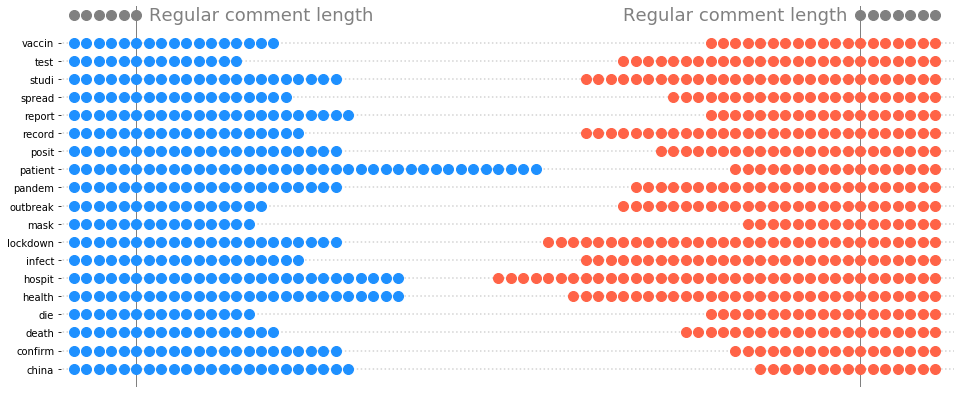

In [126]:
median_other_rep = dfrep[dfrep.covidcoef == 0].tokens.apply(len).median()
median_other_dem = dfdem[dfdem.covidcoef == 0].tokens.apply(len).median()

MEDIANS = {}
for i, word_i in enumerate(token_names):
    
    median_wi_rep = dfrep[dfrep.tokens.apply(HasCOVIDword) == True].tokens.apply(len).median()
    median_wi_dem = dfdem[dfdem.tokens.apply(HasCOVIDword) == True].tokens.apply(len).median()
    MEDIANS[word_i] = {'rep' : median_wi_rep, 'dem' : median_wi_dem}
    
middlespace = 7
total_length = max([MEDIANS[wi]['rep'] + MEDIANS[wi]['dem'] for wi in MEDIANS.keys()]) + middlespace

sw = 100

fig, ax = plt.subplots(1,1,figsize = (16,7))
for i, word_i in enumerate(token_names):

    m1 = MEDIANS[word_i]['dem']
    m2 = MEDIANS[word_i]['rep']
    range1 = range(int(m1))
    range2 = range(int(total_length - m2),int(total_length))
    ax.plot([-1000,1000],[i,i], lw = 1.5, ls = ':', c = 'lightgrey',zorder=0)
    ax.scatter(x=range1, y=[i for _ in range1], c = cdem, s = sw,zorder=10)
    ax.scatter(x=range2, y=[i for _ in range2], c = crep, s = sw,zorder=10)
    

m1 = median_other_dem
m2 = median_other_rep
range1 = range(int(m1))
range2 = range(int(total_length - m2),int(total_length))
top_i = len(token_names) + 0.5
ax.scatter(x=range1, y=[top_i for _ in range1], c = 'grey', s = sw)
ax.scatter(x=range2, y=[top_i for _ in range2], c = 'grey', s = sw)

ax.plot([m1-1,m1-1], [-100,100], c = 'grey', lw = 1)
ax.plot([total_length-m2-0.5,total_length-m2-0.5], [-100,100], c = 'grey', lw = 1)
    
ax.text(x=max(range1)+1,y=top_i, s='Regular comment length',va='center',ha='left', fontsize = 18, c = 'grey')
ax.text(x=min(range2)-1,y=top_i, s='Regular comment length',va='center',ha='right', fontsize = 18, c = 'grey')
    
ax.set_ylim(-1,len(token_names) + 1)
ax.set_xlim(-1,total_length)

ax.set_yticks(range(len(token_names)))
ax.set_yticklabels(token_names)

ax.set_xticks([])
fig.patch.set_visible(False)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["bottom"].set_visible(False)
ax.spines["left"].set_visible(False)

plt.show()

In [127]:
for w_i in controversy_topics:
    dfdem[w_i] = dfdem.comments.apply(lambda x: CountWord(x, w_i))
    dfrep[w_i] = dfrep.comments.apply(lambda x: CountWord(x, w_i))

dfdem_agg = dfdem[['day'] + controversy_topics].groupby('day').agg(np.sum)
dfrep_agg = dfrep[['day'] + controversy_topics].groupby('day').agg(np.sum)

for w in controversy_topics:
    
    name_sm = '_'.join([w,'ks'])
    # Republican
    x = dfdem_agg.index.to_numpy()
    y = dfdem_agg[w].to_numpy()
    dfdem_agg[name_sm] = localreg(x, y, x0 = x, kernel=rbf.epanechnikov, width=14, frac=None)
    # Democrat
    x = dfrep_agg.index.to_numpy()
    y = dfrep_agg[w].to_numpy()
    dfrep_agg[name_sm] = localreg(x, y, x0 = x, kernel=rbf.epanechnikov, width=14, frac=None)

In [134]:
WordSizes = {}
max_size = 0
for w in controversy_topics:
    s_dem = dfdem[w].sum()/N_dem
    s_rep = dfrep[w].sum()/N_rep
    WordSizes[w] = {'dem' : s_dem, 'rep' : s_rep}
    max_size = max([max_size, s_dem, s_rep])

    
sizes_dem = [WordSizes[w]['dem']/max_size for w in controversy_topics]
sizes_rep = [WordSizes[w]['rep']/max_size for w in controversy_topics]

In [254]:
side_dem

0.3276260606257688

In [293]:
p1p2 = []
colors_repdem = {'rep' : crep, 'dem' : cdem}
sr_name = {'rep' : 'r/republican', 'dem' : 'r/democrats'}

for p in ['dem','rep']:

    p1 = figure(plot_width= 200, plot_height=200,title = None,
                x_range=(0,1),y_range = (0,1), tools = '', tooltips = None)
    
    text1 = Text(x='x', y='y', text="text", text_font_size = '14pt',
                  text_color = 'grey', text_baseline = 'top', text_align = 'left')
    
    text_i = 'Proportion of posts\nfrom 2020\nmentioning COVID\nin'
    r_text = p1.add_glyph(ColumnDataSource(dict(x=[0.05], y=[0.95], text=[text_i])), text1) 
    
    text_i = sr_name[p]
    text1 = Text(x='x', y='y', text="text", text_font_size = '14pt', text_font_style = 'bold',
                 text_color = 'grey', text_baseline = 'top', text_align = 'left')
    r_text = p1.add_glyph(ColumnDataSource(dict(x=[0.155], y=[0.54], text=[text_i])), text1) 

    side1 = np.sqrt(sum([WordSizes[w][p] for w in controversy_topics]))
    rect1 = p1.rect(x=0, y = 0, height = side_dem, width = side_dem,
                    fill_color = colors_repdem[p], fill_alpha = 1, line_color = None)

    p1.xaxis.axis_label = ""
    p1.yaxis.axis_label = ""
    p1.xaxis.visible = False
    p1.yaxis.visible = False
    p1.grid.ticker = np.linspace(0,1,11)
    p1.grid.visible = True
    p1.background_fill_alpha = 1

    #p1.outline_line_color = None
    #p1.border_fill_color = None

    p1.background_fill_color = "seashell"

    p1p2.append(p1)

show(gridplot(p1p2, ncols = 2))

In [247]:
List_of_plots = []

for indx,w_i in enumerate(controversy_topics):
        
    s0 = sizes_rep[indx]
    s1 = sizes_dem[indx]

    scale = 72
    fontsize0 = ''.join([str(scale*s0), 'pt'])
    fontsize1 = ''.join([str(scale*s1), 'pt'])

    
        # smooth trend??
    name_sm = '_'.join([w_i,'ks'])
    ysm_rep = [max([y/N_rep,0]) for y in dfrep_agg[name_sm]]
    ysm_dem = [max([y/N_dem,0]) for y in dfdem_agg[name_sm]]
    xrep = range(dfrep_agg.shape[0])
    xdem = range(dfdem_agg.shape[0]) 
    
    maxy = 1.07*max(ysm_rep+ysm_dem)
    miny = -0.07*max(ysm_rep+ysm_dem)
    
    minx = 1
    maxx = 365
    
    xcenter = (maxx-minx)/2
    ycenter = (maxy-miny)/2
    
    p1 = figure(plot_width= 320, plot_height=90,title = None,
               x_range=(minx,maxx),y_range = (miny,maxy), tools = '', tooltips = None)
    
    label0 = Label(x=xcenter, y=ycenter, text=w_i, text_font_size = fontsize0, text_color = crep,
                    border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                    background_fill_color=None, background_fill_alpha=1.0,
                    text_baseline = 'middle', text_align = 'center',
                    level='overlay')
    label1 = Label(x=xcenter, y=ycenter, text=w_i, text_font_size = fontsize1, text_color = cdem,
                    border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                    background_fill_color=None, background_fill_alpha=1.0,
                    text_baseline = 'middle', text_align = 'center',
                    level='overlay')
    
       
    p1.line(xrep,ysm_rep, line_color = crep, line_width = 2)
    p1.line(xdem,ysm_dem, line_color = cdem, line_width = 2)
    
    
    r_rect = p1.rect(x=-10, y = -1, height = 20, width = 900, fill_color = 'seashell', fill_alpha = 0.6)
    selected_rect = Rect(fill_alpha=0., fill_color = 'white')
    r_rect.hover_glyph = selected_rect 
    
    hover1 = HoverTool(tooltips=TOOLTIPS_title,renderers = [r_rect], mode = 'mouse')
    p1.tools.append(hover1)   
        
    #p1.circle(0.5, 0.5, fill_alpha = 0, line_alpha = 0)
   
    p1.add_layout(label0)
    p1.add_layout(label1)  

    # Adjusting plot parameters
    p1.xaxis.axis_label = ""
    p1.yaxis.axis_label = ""
    p1.xaxis.visible = False
    p1.yaxis.visible = False
    p1.grid.visible = False
    p1.background_fill_alpha = 1
    
    p1.outline_line_color = None
    p1.background_fill_color = None
    p1.border_fill_color = None
    
    p1.background_fill_color = "seashell"
    
    List_of_plots.append(p1)
    
p_all = gridplot(List_of_plots, ncols=3)

show(p_all)

In [243]:
prep = figure(plot_width=1000, plot_height=250, title = None,
           tools = tools_to_show, tooltips = None, x_range=(1,360), x_axis_type = 'linear')

nf = dfrep.shape[0]/(dfrep.shape[0] + dfdem.shape[0])

smooth_data_rep = dfrep_agg[['_'.join([s,'ks']) for s in token_names]]

WORDS_IN_TOPIC = smooth_data_rep.columns.tolist()
bar ={} # bar-information for plotting
x_period_rep = smooth_data_rep.index.to_numpy()

tools_to_show = 'hover'

probs0_rep = [-x/2 for x in smooth_data_rep.sum(axis=1).to_list()]
for indx, wi in enumerate(token_names):
    
    word_i = '_'.join([wi,'ks'])
    
    # Selecting hour and probabilities for plotting category i
    probs1_rep = smooth_data_rep[word_i].to_list()
    probs_rep = [max(x[0],0) + x[1] for x in zip(probs1_rep,probs0_rep)]

    bar[word_i] = prep.varea(x = list(x_period_rep), y1 = probs0_rep, y2 = probs_rep, muted_color = crep, 
                      muted_alpha = 0.7,muted = True,
                      color = crep, alpha = 1, name = word_i)
    
    selected_area = VArea(fill_alpha=1, fill_color = crep)
    bar[word_i].hover_glyph = selected_area
    probs0_rep = probs_rep

prep.yaxis.axis_label = None

prep.yaxis.ticker = [-10,0,10]

prep.grid.visible = False
prep.background_fill_color = 'white'
prep.background_fill_alpha = 1

prep.outline_line_color = None
prep.xaxis.visible = False
prep.background_fill_color = None
prep.border_fill_color = None


pdem = figure(plot_width=1000, plot_height=250, title = None,
           tools = tools_to_show, tooltips = None, x_range=(1,360), x_axis_type = 'linear')

nf = dfdem.shape[0]/(dfrep.shape[0] + dfdem.shape[0])

smooth_data_dem = dfdem_agg[['_'.join([s,'ks']) for s in token_names]]
probs0_dem = [-x/2 for x in smooth_data_dem.sum(axis=1).to_list()]
x_period_dem = smooth_data_dem.index.to_numpy()

for indx, wi in enumerate(token_names):
    
    word_i = '_'.join([wi,'ks'])

    probs1_dem = [x for x in smooth_data_dem[word_i].to_list()]
    probs_dem = [max(x[0],0) + x[1] for x in zip(probs1_dem,probs0_dem)]
     # adding bar for category i
    bar[word_i] = pdem.varea(x = list(x_period_dem), y1 = probs0_dem, y2 = probs_dem, muted_color = cdem, 
                          muted_alpha = 0.7,muted = True,
                          color = cdem, alpha = 1, name = word_i)
    selected_area = VArea(fill_alpha=1, fill_color = cdem)
    bar[word_i].hover_glyph = selected_area
    
    probs0_dem = probs_dem

pdem.yaxis.axis_label = None

pdem.yaxis.ticker = [-10,0,10]

pdem.grid.visible = False
pdem.background_fill_color = 'white'
pdem.background_fill_alpha = 1

pdem.outline_line_color = None
pdem.xaxis.visible = False
pdem.background_fill_color = None
pdem.border_fill_color = None
        

show(column(prep, pdem))

__- Include smooth timeline in these too !!!__


__- Include the proportion of the comments using these words__

In [178]:
from sklearn.linear_model import LinearRegression
from math import ceil


items = [] # items for legend
lines ={} # bar-information for plotting
days = list(range(106))

rngsize = 10
TOOLS = ""

List_of_plots = []

datest['zero'] = 0
c1 = 'orangered'
c2 = 'lightcoral'

impact_metric = 'num_comments'
Nobs = min(N_rep, N_dem)

NEUTRALITY = {}


# Generating example/first plot
indx = 0
w_i = controversy_topics[indx]

y_rep = [j/N_rep for j in topww[w_i][:Nobs]]
y_dem = [j/N_dem for j in topww1[w_i][:Nobs]]

max_count = max(y_rep + y_dem)
maxxy = 1.05*max_count #+ 1
minxy = -0.05*max_count

X_rep = np.array(y_rep).reshape(-1,1)
reg = LinearRegression(fit_intercept = False).fit(X=X_rep, y=y_dem)
R2 = reg.score(X=X_rep, y=y_dem)
slope = reg.coef_[0]
NEUTRALITY[w_i] =  R2, np.exp(R2)*np.tanh(-(slope-1))


p_1 = figure(plot_width= 300, plot_height=300,
             title = 'Monthly mentions of "china" in (*)', 
             x_range=(minxy,maxxy),y_range = (minxy,maxxy), tools = TOOLS)

center_xy = (maxxy+minxy)/2

label_i = Label(x=center_xy, y=center_xy, text=w_i, text_font_size = '28pt',
                border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                background_fill_color=None, background_fill_alpha=1.0,
                text_baseline = 'middle', text_align = 'center',
                level='underlay')

p_1.add_layout(label_i)

p_1.line(y=[-10,10], x=[-10,10], color=c2, alpha = 1, line_width = 1.5, line_dash = 'dashed')
r = p_1.scatter(x=y_rep, y=y_dem, color=c1, alpha = 1, size=8)


# Adjusting plot parameters
#p.x_range.range_padding = 0.05
p_1.xaxis.axis_label = "(*) r/republican"
p_1.yaxis.axis_label = "(*) r/democrats"
p_1.xaxis.visible = True
p_1.yaxis.visible = True
p_1.yaxis.axis_line_width = 1
p_1.yaxis.ticker = []
p_1.xaxis.axis_line_width = 1
p_1.xaxis.ticker = []
p_1.grid.visible = False
p_1.background_fill_color = 'white'
p_1.background_fill_alpha = 1

p_1.outline_line_color = None
p_1.border_fill_color = None

p_1.background_fill_color = "seashell"

# Generating the rest
for indx,w_i in enumerate(controversy_topics[1:]):
    
    y_rep = [j/N_rep for j in topww[w_i][:Nobs]]
    y_dem = [j/N_dem for j in topww1[w_i][:Nobs]]
    
    max_count = max(y_rep + y_dem)
    maxxy = 1.05*max_count #+ 1
    minxy = -0.05*max_count
    
    X_rep = np.array(y_rep).reshape(-1,1)
    reg = LinearRegression(fit_intercept = False).fit(X=X_rep, y=y_dem)
    R2 = reg.score(X=X_rep, y=y_dem)
    slope = reg.coef_[0]
    NEUTRALITY[w_i] =  R2, np.exp(R2)*np.tanh(-(slope-1))
        
    
    p = figure(plot_width= 150, plot_height=150, 
               title = None, x_range=(minxy,maxxy),y_range = (minxy,maxxy), tools = TOOLS)
    
    center_xy = (maxxy+minxy)/2
    
    label_i = Label(x=center_xy, y=center_xy, text=w_i, text_font_size = '24pt',
                    border_line_color=None, border_line_alpha=1.0, text_font_style = 'bold',
                    background_fill_color=None, background_fill_alpha=1.0,
                    text_baseline = 'middle', text_align = 'center',
                    level='underlay')

    p.add_layout(label_i)
    
    p.line(y=[-10,10], x=[-10,10], color=c2, alpha = 1, line_width = 1.5, line_dash = 'dashed')
    r = p.scatter(x=y_rep, y=y_dem, color=c1, alpha = 1, size=8)
    

    # Adjusting plot parameters
    #p.x_range.range_padding = 0.05
    p.xaxis.axis_label = ""
    p.yaxis.axis_label = ""
    p.xaxis.visible = False
    p.yaxis.visible = False
    p.grid.visible = False
    p.background_fill_color = 'white'
    p.background_fill_alpha = 1
    
    p.outline_line_color = None
    p.background_fill_color = None
    p.border_fill_color = None
    
    p.background_fill_color = "seashell"
    
    List_of_plots.append(p)
    
    
p_rest = gridplot(List_of_plots, ncols=6)

#show(p_a)

show(column(p_1, p_rest))

A covid word would be totally neutral if the slope computed above is equal to 1. However, the closer to zero, the more "republican" the word is. Analogously, the higher the value of n is, the more "democrat" the word is.

It is also interesting to check the evolution of these words in each subreddit, as well as their statistics like: how long are the comments they appear on, how many different people talk about them,...

### Rate of change

In [31]:
df2019_dem = ReadSubreddit('democrats', agg_step = agg_step, year = 2019)
df2019_rep = ReadSubreddit('republican', agg_step = agg_step, year = 2019)

In [86]:
def RateChange(word, d2019, d2020):
    
    n19 = d2019.comments.apply(lambda x: x.count(word)).sum()/d2019.shape[0]
    n20 = d2020.comments.apply(lambda x: x.count(word)).sum()/d2020.shape[0]
    
    return n20/(n20 + n19)

CHANGE_dem = {}
CHANGE_rep = {}
for w_i in token_names:
    rc_i = RateChange(w_i, d2019=df2019_dem, d2020 =dfdem)
    rc_j = RateChange(w_i, d2019=df2019_rep, d2020 =dfrep)

    CHANGE_dem[w_i] = rc_i
    CHANGE_rep[w_i] = rc_j
    
    #print(w_i, rc_i, rc_j)
    

china 0.5115812869065 0.7402918466719172
confirm 0.6016315069223523 0.5763735862494194
death 0.6511663023857638 0.6995676278740579
die 0.5587288092188664 0.5268891348038652
health 0.38484648404141114 0.4843441839753742
hospit 0.5945496181549158 0.7374674253020098
infect 0.9688216778012849 0.8837859909488557
lockdown 1.0 0.9855132349098342
mask 0.9746228524525204 0.8646298364779353
outbreak 1.0 0.9636993503686835
pandem 0.9855973516861346 1.0
patient 0.5349079897621294 0.387690509615761
posit 0.4257655380418424 0.4704491165047095
record 0.48983191651588087 0.4282997929372052
report 0.40332807065033416 0.4200293428412196
spread 0.6349806398934473 0.6840345562721281
studi 0.5731695705988765 0.4370158740931827
test 0.5544416689305143 0.59987168621601
vaccin 0.7722955332744136 0.8281690898634347


In [33]:
df3 = pd.DataFrame.from_dict({'words' : token_names,'rc_dem' : CHANGE_dem.values(),
                              'rc_rep' : CHANGE_rep.values(),
                              'n' : [n[1] for n in NEUTRALITY.values()]}, orient='index').transpose()

df3['rc'] = df3[['rc_dem','rc_rep']].mean(axis=1)
df3.head()

words    rc_dem    rc_rep         n        rc
0    china  0.511581  0.740292  0.942032  0.625937
1  confirm  0.601632  0.576374  0.361357  0.589003
2    death  0.651166  0.699568  0.831646  0.675367
3      die  0.558729  0.526889  0.624978  0.542809
4   health  0.384846  0.484344  0.169519  0.434595

In [50]:
# Reading
df3 = pd.read_csv('./data/df3.csv')
dfdem = pd.read_csv('./data/dfdem.csv')
dfrep = pd.read_csv('./data/dfrep.csv')
topww = pd.read_csv('./data/topww.csv')
topww1 = pd.read_csv('./data/topww1.csv')
df2019_dem = pd.read_csv('./data/df2019_dem.csv')
df2019_rep = pd.read_csv('./data/df2019_rep.csv')

dfrep_agg = pd.read_csv('./data/dfrep_agg.csv',header = True)
dfdem_agg = pd.read_csv('./data/dfdem_agg.csv',header = True)

In [210]:
from bokeh.models import CustomJS, Range1d, LabelSet
from bokeh.models.widgets import Div

N = list(NEUTRALITY.values())
C = list(CHANGE_dem.values())


xmax = 1.3
xmin = -1.3

df3['nn'] = 2*(df3.n - df3.n.min())/(df3.n.max()-df3.n.min()) -1

# create a new plot with the toolbar below
p = figure(plot_width=500, plot_height=500, x_range=(xmin-0.2,xmax+0.2) ,y_range = (-0.1,1.1),
           title=None, toolbar_location="below",toolbar_sticky=False, tools = 'wheel_zoom,reset,pan')

source = ColumnDataSource(data=df3)


image_bkg = path.join('.','images',''.join(['repdem3.png']))
r_image = p.image_url(url=[image_bkg], x=-1.2, y=0.5, w=50, h=50, global_alpha = 1, anchor = 'center',level='underlay')


p.line([-10,10],[0.5,0.5], line_color = 'lightgrey', line_width = 1)
p.line([0,0],[-10,10], line_color = 'lightgrey', line_width = 1)


glyph_text = Text(x='n', y='rc', text="words", 
                  x_offset = 6, y_offset = 10, 
                  text_align = 'center', text_baseline = 'middle', 
                  angle=0, text_font_size = '20pt', text_color='black', text_alpha = 1, text_font_style = 'bold')
r_text = p.add_glyph(source, glyph_text)

# p.scatter(x='n', y='rc', size=8, source=source, fill_alpha = 0, line_alpha = 0)

# labels = LabelSet(x='n', y='rc', text='words', level='glyph',
#                   source=source, render_mode='canvas',
#                   x_offset = 10, y_offset = 10, 
#                   angle=0, text_font_size = '14pt',
#                   text_color='black', text_alpha = 1, text_font_style = 'bold')

# p.add_layout(labels)

# hover2 = TapTool(renderers = [r])    
# p.tools.append(hover2)

x_ticks = [xmin, xmax]
y_ticks = [0, 1]
x_labels = ['Democrat', 'Republican']
p.xaxis.ticker = x_ticks
p.yaxis.ticker = y_ticks

p.xaxis.axis_label = "Partisanship"
p.yaxis.axis_label = "Rate of change 2019/2020"

p.xaxis.major_label_overrides = {xmin:'Democrat', xmax : 'Republican'}
p.yaxis.major_label_overrides = {0:'2019', 1 : '2020'}

# div = Div(text='', width=300)
# p.js_on_event('tap', CustomJS(args={'src': source, 'div': div}, code="""
#     if (src.selected.indices.length == 0){
#         div.text = '';
#     }
# """))


show(p)


In [ ]:
# Writing
df3.to_csv('./data/df3.csv',header = True)
dfdem.to_csv('./data/dfdem.csv',header = True)
dfrep.to_csv('./data/dfrep.csv',header = True)
topww.to_csv('./data/topww.csv',header = True)
topww1.to_csv('./data/topww1.csv',header = True)
df2019_dem.to_csv('./data/df2019_dem.csv',header = True)
df2019_rep.to_csv('./data/df2019_rep.csv',header = True)

dfrep_agg.to_csv('./data/dfrep_agg.csv',header = True)
dfdem_agg.to_csv('./data/dfdem_agg.csv',header = True)

# Discards

Streamgraphs relevant links
https://www.python-graph-gallery.com/streamchart/
https://rud.is/b/2015/03/12/streamgraph-htmlwidget-version-0-7-released-adds-support-for-markers-annotations/

In [450]:

WORDS_IN_TOPIC = smooth_data.columns.tolist()

red = Color("dodgerblue")
colors_ = [c.hex for c in list(red.range_to(Color("hotpink"), len(token_names)))]


nweeks = smooth_data.shape[0]
items = [] # items for legend
bar ={} # bar-information for plotting
weeks = x_period # adding 1 to 0:23 for readibiltiy

tooltips = [("word", "$name")]
tools_to_show = 'box_zoom,hover,reset,tap'

p = figure(plot_width=1000, plot_height=400, title = 'Evolution of words in topic i',
           tools = tools_to_show, tooltips = tooltips, x_axis_type="datetime")

dates = smooth_data.index.to_list()
for indx, wi in enumerate(token_names):
    
    word_i = '_'.join([wi,'ks'])
     # Selecting hour and probabilities for plotting category i
    probs = smooth_data[word_i].to_list()
     # adding bar for category i
    bar[word_i] = p.line(x = dates, y = probs, muted_color = colors_[indx], muted_alpha = 0.4, muted = True,
                         color = colors_[indx], alpha = 1, line_width = 1.5, name = word_i)
    
    selected_line = Line(line_alpha=1, line_color=colors_[indx], line_width = 2.5)

    # I add the selection glyph because I want to fix a particular line for comparing
    bar[word_i].hover_glyph = selected_line
    bar[word_i].selection_glyph = selected_line
        
# Adding info of category i for the legend
    items.append((wi, [bar[word_i]]))

 # Adjusting plot parameters
p.x_range.range_padding = 0.05
#p.xaxis.axis_label = "Week of the year"
p.yaxis.axis_label = "Probability of using the word"
 # Adusting legend information
legend = Legend(items=items, location=(0, 10))
p.add_layout(legend, 'right')
p.legend.click_policy="hide"

show(p) 

In [ ]:
def ReturnCoocMat(t_m, wl):
    
    # Returns a N-square matrix where N is the number of words of a topic.
    # The matrix diagonal is always 1
    # The matrix is symetric
    
    # When the word i is said, how many times j is said.

    from collections import Counter
    
    nwl = len(wl)
    mat = np.zeros((nwl,nwl))
    
    tokens_tm = tokenizer(t_m)
    c = Counter(x for x in tokens_tm if x)
    # selecting only the topic words
    c_topic = Counter({k: 0  for k in wl})
    
    c_topic.update(c)
    
    for i,w in enumerate(wl):
        if c_topic[w] != 0:
            mat[i,i] = 1
            for j in range(i+1, nwl):
                mat[i,j] = mat[j,i] = c_topic[wl[j]]/c_topic[w]
    
    return mat

# Generating a mean of matrices
words_in_matrix = token_names

Nwt = len(words_in_matrix)
Mat = np.zeros((Nwt,Nwt))

for title in dc19.title:
    Mat = Mat + ReturnCoocMat(title, words_in_matrix)
    
Mat = Mat/dc19.shape[0]

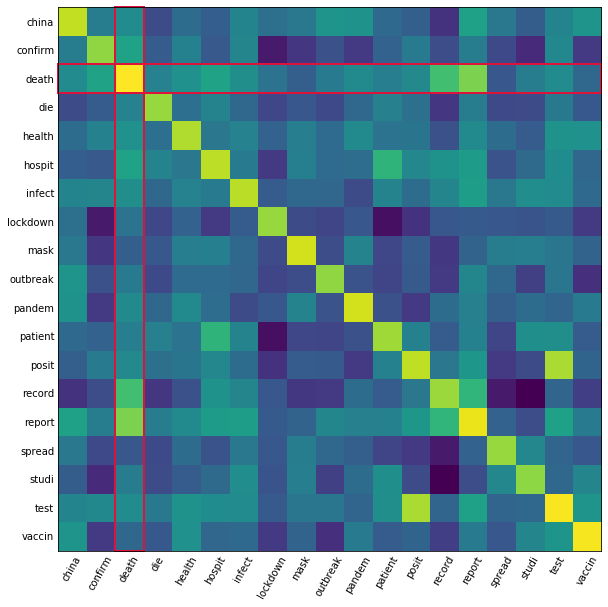

In [449]:
from sklearn.preprocessing import normalize
from matplotlib.patches import Rectangle
import seaborn as sns

labels = words_in_matrix
N = len(labels)

#####

Matlog = np.log(Mat)

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(Matlog)

ax.set_yticks(range(len(words_in_matrix)))
ax.set_yticklabels(words_in_matrix)
ax.set_xticks(range(len(words_in_matrix)))
ax.set_xticklabels(words_in_matrix, rotation = 60)

wanted_label = 'death'
wanted_index = labels.index(wanted_label)
x, y, w, h = -0.5, wanted_index-0.5, N, 1
for _ in range(2):
    ax.add_patch(Rectangle((x, y), w, h, fill=False, edgecolor='crimson', lw=2, clip_on=False))
    x, y = y, x # exchange the roles of x and y
    w, h = h, w # exchange the roles of w and h
ax.tick_params(length=0)

# Hide grid lines
ax.grid(False)

plt.show()

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,9))

red = Color("dodgerblue")
colors_ = [c.hex for c in list(red.range_to(Color("hotpink"), len(token_names)))]

areas_ks = smooth_data.to_numpy().transpose()
ax.stackplot(x_period,*areas_ks, baseline='wiggle', colors=colors_, edgecolor = 'white')
ax.set_xlim(23,355)

plt.show()

In [ ]:

nrows=5
ncols=4

fig, ax = plt.subplots(nrows,ncols,figsize=(14,12))

Nobs = min(topww.shape[0], topww.shape[0])

y_rep = topww['mask'][:Nobs]
y_dem = topww1['mask'][:Nobs]

WORDS = controversy_topics
NEUTRALITY = {}
ij = 0
for i in range(nrows):
    for j in range(ncols):
        
        if(ij < 19):
        
            w_ij = WORDS[ij]
            y_rep = topww[w_ij][:Nobs]
            y_dem = topww1[w_ij][:Nobs]

            xy_upperlim = 1.01*max(y_rep + y_dem)
            xy_lowerlim = -0.05*xy_upperlim

            ax[i,j].text(xy_upperlim/2, xy_upperlim/2, w_ij, fontsize = 20)
            ax[i,j].plot([-300,300],[-300,300], c = 'grey')

            ax[i,j].scatter(x=y_rep, y=y_dem, s= 40)
            ax[i,j].set_xlim(xy_lowerlim,xy_upperlim)
            ax[i,j].set_ylim(xy_lowerlim,xy_upperlim)
            
            X_rep = np.array(y_rep).reshape(-1,1)
            reg = LinearRegression(fit_intercept = False).fit(X=X_rep, y=y_dem)
            R2 = reg.score(X=X_rep, y=y_dem)
            slope = reg.coef_[0]
            NEUTRALITY[w_ij] =  R2, np.exp(R2)*np.tanh(-(slope-1)) #tanh to make it symetric around 1

            ax[i,j].text(0.1*xy_upperlim, 0.8*xy_upperlim, str(round(R2,2)), fontsize = 20)
            ax[i,j].text(0.1*xy_upperlim, 0.4*xy_upperlim, str(round(slope,2)), fontsize = 20)
            ax[i,j].grid(False)       

            ij += 1
        

plt.show()